# Sample Code of PertMap (Perturbation-based Saliency Map)

### PertMap generates a heatmap where the CNN has focused on.

* Satoshi Hara, Kouichi Ikeno, Tasuku Soma, Takanori Maehara. [Maximally Invariant Data Perturbation as Explanation]((https://arxiv.org/abs/1806.07004)). arXiv:1806.07004, 2018.

### The example below generates a heatmap for VGG16.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cplex
import tensorflow as tf
import skimage
import skimage.io
import skimage.transform
VGG_MEAN = [103.939, 116.779, 123.68]

## Setup VGG16

#### To begin with, download the weight file of VGG16 from the link in [this repository](https://github.com/machrisaa/tensorflow-vgg).
We use the VGG16 implementation in the repository, also.

In [2]:
def get_conv_filter(data_dict, name):
    return tf.constant(data_dict[name][0], name="filter")
    
def get_bias(data_dict, name):
    return tf.constant(data_dict[name][1], name="biases")

def get_fc_weight(data_dict, name):
    return tf.constant(data_dict[name][0], name="weights")

In [3]:
def max_pool(bottom, name):
    return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

def conv_layer(bottom, data_dict, name):
    with tf.variable_scope(name):
        filt = get_conv_filter(data_dict, name)
        conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')
        conv_biases = get_bias(data_dict, name)
        bias = tf.nn.bias_add(conv, conv_biases)
        relu = tf.nn.relu(bias)
        return relu

def fc_layer(bottom, data_dict, name):
    with tf.variable_scope(name):
        shape = bottom.get_shape().as_list()
        dim = 1
        for d in shape[1:]:
            dim *= d
        x = tf.reshape(bottom, [-1, dim])
        weights = get_fc_weight(data_dict, name)
        biases = get_bias(data_dict, name)
        fc = tf.nn.bias_add(tf.matmul(x, weights), biases)
        return fc

In [4]:
def build(graph):
    layer = {}
    data_dict = np.load('./vgg16.npy', encoding='latin1').item()
    with graph.as_default():
        image = tf.placeholder(tf.float32, [None, 224, 224, 3])
        layer['image'] = image
        rgb_scaled = image * 255.0

        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=rgb_scaled)
        assert red.get_shape().as_list()[1:] == [224, 224, 1]
        assert green.get_shape().as_list()[1:] == [224, 224, 1]
        assert blue.get_shape().as_list()[1:] == [224, 224, 1]
        bgr = tf.concat(axis=3, values=[
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ])
        assert bgr.get_shape().as_list()[1:] == [224, 224, 3]

        # layer-1
        conv1_1 = conv_layer(bgr, data_dict, 'conv1_1')
        conv1_2 = conv_layer(conv1_1, data_dict, 'conv1_2')
        pool1 = max_pool(conv1_2, 'pool1')
        layer['conv1_1'] = conv1_1
        layer['conv1_2'] = conv1_2
        layer['pool1'] = pool1

        # layer-2
        conv2_1 = conv_layer(pool1, data_dict, 'conv2_1')
        conv2_2 = conv_layer(conv2_1, data_dict, 'conv2_2')
        pool2 = max_pool(conv2_2, 'pool2')
        layer['conv2_1'] = conv2_1
        layer['conv2_2'] = conv2_2
        layer['pool2'] = pool2
        
        # layer-3
        conv3_1 = conv_layer(pool2, data_dict, 'conv3_1')
        conv3_2 = conv_layer(conv3_1, data_dict, 'conv3_2')
        conv3_3 = conv_layer(conv3_2, data_dict, 'conv3_3')
        pool3 = max_pool(conv3_3, 'pool3')
        layer['conv3_1'] = conv3_1
        layer['conv3_2'] = conv3_2
        layer['conv3_3'] = conv3_3
        layer['pool3'] = pool3

        # layer-4
        conv4_1 = conv_layer(pool3, data_dict, 'conv4_1')
        conv4_2 = conv_layer(conv4_1, data_dict, 'conv4_2')
        conv4_3 = conv_layer(conv4_2, data_dict, 'conv4_3')
        pool4 = max_pool(conv4_3, 'pool4')
        layer['conv4_1'] = conv4_1
        layer['conv4_2'] = conv4_2
        layer['conv4_3'] = conv4_3
        layer['pool4'] = pool4

        # layer-5
        conv5_1 = conv_layer(pool4, data_dict, 'conv5_1')
        conv5_2 = conv_layer(conv5_1, data_dict, 'conv5_2')
        conv5_3 = conv_layer(conv5_2, data_dict, 'conv5_3')
        pool5 = max_pool(conv5_3, 'pool5')
        layer['conv5_1'] = conv5_1
        layer['conv5_2'] = conv5_2
        layer['conv5_3'] = conv5_3
        layer['pool5'] = pool5

        # layer-6
        fc6 = fc_layer(pool5, data_dict, 'fc6')
        assert fc6.get_shape().as_list()[1:] == [4096]
        relu6 = tf.nn.relu(fc6)
        layer['fc6'] = fc6
        layer['relu6'] = relu6

        # layer-7
        fc7 = fc_layer(relu6, data_dict, 'fc7')
        relu7 = tf.nn.relu(fc7)
        layer['fc7'] = fc7
        layer['relu7'] = relu7

        # layer-8
        fc8 = fc_layer(relu7, data_dict, 'fc8')
        prob = tf.nn.softmax(fc8, name='prob')
        layer['fc8'] = fc8
        layer['prob'] = prob
    return layer

## Load Image

Use a sample image from [here](https://www.pexels.com/search/dog/).

In [5]:
%%capture

# download image
!wget 'https://images.pexels.com/photos/58997/pexels-photo-58997.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=350' '-O' './dog.jpg'

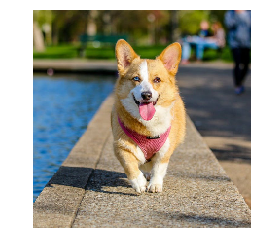

In [6]:
def load_image(path):
    img = skimage.io.imread(path)
    img = img / 255.0
    assert (0 <= img).all() and (img <= 1.0).all()
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    resized_img = skimage.transform.resize(crop_img, (224, 224), mode='reflect')
    return resized_img

# show image
img = load_image('./dog.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

## Compute Outputs & Gradients of VGG16

In [7]:
# number of noises used for smoothing
num_noise = 10

# set to zero for no smoothing
#num_noise = 0

In [8]:
with tf.Graph().as_default():
    
    # setup VGG16
    sess = tf.Session()
    layer = build(tf.get_default_graph())
    
    # input graident
    layer['idx'] = tf.placeholder(tf.int32)
    layer['grad'] = tf.gradients(layer['fc8'][0, layer['idx']], layer['image'])
    sess.run(tf.global_variables_initializer())
    
    # compute outputs & graidents w/ noises
    n = []
    z = []
    g = []
    for itr in range(num_noise+1):
        np.random.seed(itr)
        
        # noise
        if itr == 0:
            noise = 0.00 * np.random.randn(224, 224, 3)
        else:
            noise = 0.05 * np.random.randn(224, 224, 3)
        n.append(noise)
        noisy_img = (img + noise).reshape((1, 224, 224, 3))
        
        # output
        zi = sess.run(layer['fc8'], feed_dict={layer['image']: noisy_img})
        z.append(zi)
        
        # gradient
        gsub = []
        for i in range(1000):
            gi = sess.run(layer['grad'], feed_dict={layer['image']: noisy_img, layer['idx']: i})
            gsub.append(gi[0][0, :, :, :])
        g.append(gsub)

In [9]:
y = z[0][0, :]
c = np.argmax(y)
n = np.array(n)
z = np.array(z)
g = np.array(g)
print('Classification Result:', c)

Classification Result: 263


## Proposed Method w/ Parameter Sharing

In [10]:
z = z[:, 0, c][:, np.newaxis] - z[:, 0, np.arange(1000) != c] # output diff.
z = z.reshape((z.shape[0], -1))
h = g[:, c, :, :, :][:, np.newaxis, :, :, :] - g[:, np.arange(1000) != c, :, :, :] # grad diff.
h = h.astype(np.float32)
print(z.shape)
print(h.shape)
print(n.shape)

(11, 999)
(11, 999, 224, 224, 3)
(11, 224, 224, 3)


In [11]:
# hyper-parameters
delta = 0.1 # maximum perturbation size
lam = 1e-4 # penalty weight for the soft-constraint

# parameter sharing in 8x8 patch
x = img.flatten()
xdim = x.size // 64

# LP - obj and bounds
obj = [1.0] * (2 * xdim)
obj.append(- lam * 2 * xdim)
lb = [0.0] * (2 * xdim + 1)
ub = [delta] * (2 * xdim)
ub.append(cplex.infinity)

# LP - constraints
Aneq = []
bneq = []
sen = ''
with tf.Graph().as_default():
    v = tf.placeholder(tf.float32, [None, 224, 224, 1])
    w = np.ones((8, 8, 1, 1)).astype(np.float32)
    conv = tf.nn.conv2d(v, w, strides=(1, 8, 8, 1), padding='VALID')
    sess = tf.Session(graph = tf.get_default_graph())
    for i in range(g.shape[0]):
        valn = []
        valp = []
        for k in range(3):
            hn = (h[i, :, :, :, k] * (h[i, :, :, :, k] < 0))[:, :, :, np.newaxis]
            hp = (h[i, :, :, :, k] * (h[i, :, :, :, k] >= 0))[:, :, :, np.newaxis]
            convn = sess.run(conv, feed_dict={v:hn})
            convp = sess.run(conv, feed_dict={v:hp})
            valn.append((-convn).reshape(convn.shape[0], -1))
            valp.append(convp.reshape(convp.shape[0], -1))
        valn = np.array(valn).transpose(1, 2, 0)
        valp = np.array(valp).transpose(1, 2, 0)
        valall = np.c_[valn.reshape(valn.shape[0], -1), valp.reshape(valp.shape[0], -1)]
        for j in range(valall.shape[0]):
            val = valall[j, :].tolist()
            val.append(-1.0)
            idx = list(range(2 * xdim))
            idx.append(2 * xdim)
            Aneq.append([idx, val])
            bneq.append(float(z[i, j] + np.sum(g[i, j, :] * n[i, :])))
            sen += 'L'
            
# LP - solve
prob = cplex.Cplex()
prob.objective.set_sense(prob.objective.sense.maximize)
prob.variables.add(obj=obj, lb=lb, ub=ub)
prob.linear_constraints.add(lin_expr=Aneq, rhs=bneq, senses=sen)
#prob.set_log_stream(None)
#prob.set_error_stream(None)
#prob.set_warning_stream(None)
#prob.set_results_stream(None)
prob.solve()
w = np.array(prob.solution.get_values())
u, v, r = w[:xdim], w[xdim:-1], w[-1]

CPXPARAM_Read_DataCheck                          1
CPXPARAM_Read_APIEncoding                        "UTF-8"
CPXPARAM_MIP_Strategy_CallbackReducedLP          0
Parallel mode: deterministic, using up to 6 threads for concurrent optimization.
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 6.08 sec. (3600.42 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =           295.663196
Reinitializing dual norms . . .

Dual simplex solved model.



## Plot Results

In [12]:
# scores of PertMap, Grad, and SmooghGrad
score_pertmap = 2 * delta - np.kron(np.mean((u + v).reshape(28, 28, 3), axis=2), np.ones((8, 8)))
score_grad = np.mean(np.abs(g[0, c, :, :, :]), axis=2)
score_smoothgrad = np.mean(np.mean(np.abs(g[:, c, :, :, :]), axis=3), axis=0)

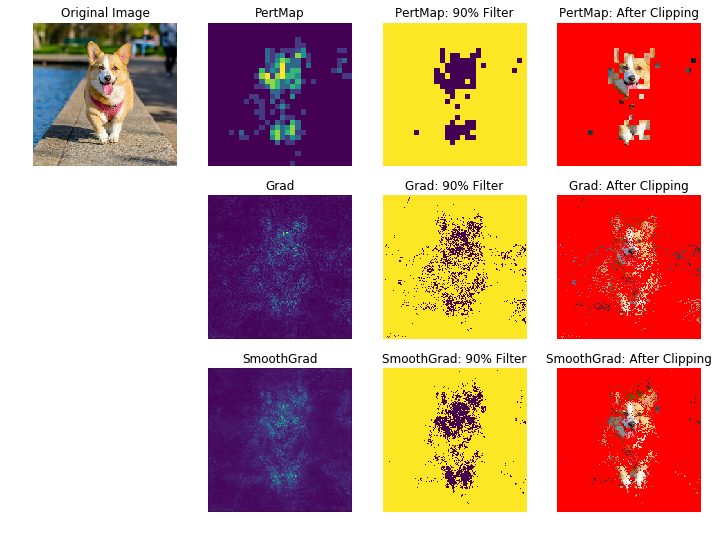

In [13]:
red = np.ones((224, 224, 3))
red[:, :, 1:] = 0

# plot
plt.figure(figsize=(12, 9))
plt.subplot(3, 4, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

# PertMap
plt.subplot(3, 4, 2)
plt.imshow(score_pertmap)
plt.axis('off')
plt.title('PertMap')
plt.subplot(3, 4, 3)
filt = (score_pertmap <= np.percentile(score_pertmap, 90))
plt.imshow(filt)
plt.axis('off')
plt.title('PertMap: 90% Filter')
plt.subplot(3, 4, 4)
plt.imshow(img * (1 - filt)[:, :, np.newaxis] + red * filt[:, :, np.newaxis])
plt.axis('off')
plt.title('PertMap: After Clipping')

# Grad
plt.subplot(3, 4, 6)
plt.imshow(score_grad)
plt.axis('off')
plt.title('Grad')
plt.subplot(3, 4, 7)
filt = (score_grad <= np.percentile(score_grad, 90))
plt.imshow(filt)
plt.axis('off')
plt.title('Grad: 90% Filter')
plt.subplot(3, 4, 8)
plt.imshow(img * (1 - filt)[:, :, np.newaxis] + red * filt[:, :, np.newaxis])
plt.axis('off')
plt.title('Grad: After Clipping')

# SmoothGrad
plt.subplot(3, 4, 10)
plt.imshow(score_smoothgrad)
plt.axis('off')
plt.title('SmoothGrad')
plt.subplot(3, 4, 11)
filt = (score_smoothgrad <= np.percentile(score_smoothgrad, 90))
plt.imshow(filt)
plt.axis('off')
plt.title('SmoothGrad: 90% Filter')
plt.subplot(3, 4, 12)
plt.imshow(img * (1 - filt)[:, :, np.newaxis] + red * filt[:, :, np.newaxis])
plt.axis('off')
plt.title('SmoothGrad: After Clipping')

plt.show()